In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load the clean data into variables
DataPath = "Processed Data/"

dicts = ['EFI_ID_List', 'metabolite_dict', 'Protein_seq_dict']

with open(DataPath + 'EFI_ID_List.p', 'rb') as EFI_ID:
    EFI_ID_List = pickle.load(EFI_ID)

with open(DataPath + 'metabolite_dict.p', 'rb') as metabolite:
    metabolite_dict = pickle.load(metabolite)

with open(DataPath + 'Protein_seq_dict.p', 'rb') as Protein_seq:
    Protein_seq_dict = pickle.load(Protein_seq)

activations = pd.read_csv(DataPath + 'activations.csv', index_col=0)

In [ ]:
def Heatmap(df=activations,xlabel="Protein Index", ylabel="Substrate Index", dpi=400):
    # Generate heatmap of raw data and activations
    plt.figure(dpi=dpi)
    heatmap = plt.imshow(df) # Creates heatmap using input dataframe/array
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.jet() # Specifies the "jet" colormap
    plt.colorbar() # Displayes colourbar
    plt.show(heatmap)
    plt.close()

def Heatmap_Vector(df=activations,ylabel="Protein Index", xlabel="Substrate Index", my_dpi=100):
    # Generate heatmap from data contained in a vector using seaborn
    plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
    heatmap = plt.imshow(df) # Creates heatmap using input dataframe/array
    plt.ylabel(ylabel)
    plt.jet() # Specifies the "jet" colormap
    plt.colorbar() # Displayes colourbar
    plt.show(heatmap)
    plt.close()

Heatmap_Vector(pd.DataFrame(activations.iloc[0,:]))

In [ ]:
def AnalyzeSubstrate(df=activations, SID=0):
    act_df = df.iloc[0,:]

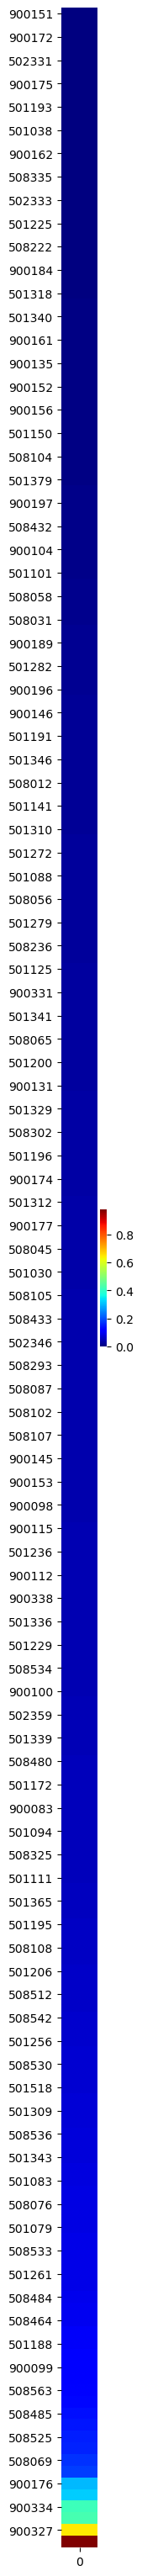

In [69]:

fig, ax = plt.subplots(figsize=(0.7,40), dpi=100)
df_view = pd.DataFrame(activations.iloc[0,:])
df_view = df_view.sort_values(by=0, ascending=True)
hmap = sns.heatmap(df_view, cmap='jet', ax=ax)

In [67]:
df_view = pd.DataFrame(activations.iloc[0,:])
df_view

,0
501030,0.0380
501036,0.0280
501038,0.0000
501045,0.0015
501052,0.0320
...,...
900333,0.0020
900334,0.4165
900335,0.0050
900336,0.0110
